# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"

### 조건
    * 각각의 ISBN끼리 리뷰를 합쳐서 테스트
    * 형용사 : 길이가 1이상
    * topics : 5
    * 테스트 : 5

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [3]:
import konlpy
from konlpy.tag import Okt

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [5]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\multicampus\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\multicampus\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## <전처리>

In [6]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

### ISBN을 기준으로 리뷰를 모은 뒤 재조합

## <토큰화>

#### 분류 테스트 

In [7]:
okt = Okt()

----

### 기존 데이터 가져오기

In [8]:
# 불러오기
import pickle

book_morphs_with_isbn_pos_non_stopword = []
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt', 'rb') as lf:
    book_morphs_with_isbn_pos_non_stopword = pickle.load(lf)
    
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [9]:
print(len(book_morphs_with_isbn_pos_non_stopword))

print(book_morphs_with_isbn_pos_non_stopword[10])

42559
[9788974825515, [('아이', 'Noun'), ('에게', 'Josa'), ('중국어', 'Noun'), ('에', 'Josa'), ('대한', 'Noun'), ('자신감', 'Noun'), ('을', 'Josa'), ('실어', 'Noun'), ('줄', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('책', 'Noun'), ('인', 'Noun'), ('것', 'Noun'), ('같다', 'Adjective'), ('열심히', 'Adverb'), ('공부', 'Noun'), ('하다', 'Verb'), ('자격증', 'Noun'), ('을', 'Josa'), ('따다', 'Verb'), ('중국어', 'Noun'), ('와', 'Verb'), ('더', 'Noun'), ('가깝다', 'Adjective'), ('지다', 'Noun'), ('하다', 'Verb')]]


In [10]:
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [11]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','을','이라',
             '라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있','죠','고','니','로','있','같',
             '어서','어요','는데','습니다','면서','많이','마','더','그렇다','의','당','좀','책','안','볼','게','안','정말','듯','이제야','여','요','게다가','같다',
            '임','로서','이제','만','인','붙이','그','저','수','가제','부터','닷','저희','적','알','쉬','못','꼭','살','제','권','제','분','나','내', '진작', '전', '뿐'
            , '대한','대해','책','좋다']

In [12]:
######### 태깅한 데이터 중에서 형용사(1이상) + 불용어 처리

book_train_adj = []
book_train_isbn = []
for (isbn, test) in book_morphs_with_isbn_pos_non_stopword :
    tts = [(word,pos) for (word,pos) in test if not word in stopwords] #불용어 처리

#     tt = [(word,pos) for (word,pos) in tts if pos in 'Noun'] # 태깅데이터 포함
#     na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장
    na = []
    for (word,pos) in tts : #형용사 : 길이가 1이상
        if pos == 'Adjective' and len(word)>1 :
#             tt.append((word,pos))
            na.append(word)
    if na : 
        book_train_adj.append(na)
        book_train_isbn.append(isbn)
#         book_na_tag.append(tt)
#         book_train_na_with_isbn.append([isbn,na])

print('**********************END***************************')
print(len(book_train_adj))
print(len(book_train_isbn))

**********************END***************************
37790
37790


In [13]:
for i in range(0,5) :
#     print(book_morphs_with_isbn_pos_non_stopword[i])
    print(book_train_adj[i])

['좋아하다']
['다르다', '유쾌하다', '유치하다']
['귀엽다', '기쁘다', '없다', '아쉽다', '아니다', '알차다']
['유익하다', '어렵다', '자세하다', '훌륭하다', '없다']
['유용하다', '많다']


----

# 정수 인코딩과 단어 집합 만들기

(인코딩값, 빈도수)

#### 데이터 셋
* 형용사 길이 > 1

In [14]:
from gensim import corpora


dictionary = corpora.Dictionary(book_train_adj)
corpus = [dictionary.doc2bow(text) for text in book_train_adj]

In [15]:
print(len(book_train_adj))
print(len(dictionary))
print(len(corpus))

37790
1605
37790


------

## 모델 평가 & 토픽 최적화

In [23]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 

coherence_values=[]

for i in range(2,20) : 
    ldamodel = LdaModel(corpus,num_topics=i,id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel,texts=book_train_adj,dictionary=dictionary) # ,topn=10
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

In [24]:
print('coherence_values : ',coherence_values)

coherence_values :  [0.6146609868413673, 0.621204387138545, 0.658765951332716, 0.6731265152065198, 0.6754335464610115, 0.6735448153493243, 0.6572880602935607, 0.6503644323567909, 0.6644216730652349, 0.66386477352115, 0.6701921321811243, 0.6715546624142685, 0.6573788759460423, 0.6499712323069412, 0.6684316689539822, 0.6621493181439599, 0.6585709852652902, 0.6593735128484814]


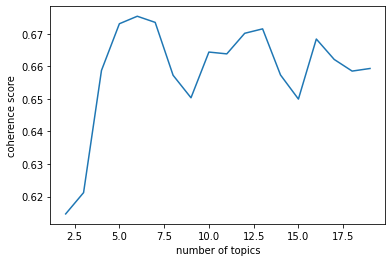

In [38]:
x=range(2,20,1)
plt.plot(x,coherence_values)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.show()

In [28]:
perplexity_values=[]

for i in range(2,20) :
    ldamodel = LdaModel(corpus,num_topics=i,id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

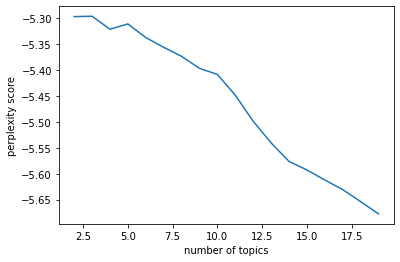

In [29]:
x=range(2,20)
plt.plot(x,perplexity_values)
plt.xlabel('number of topics')
plt.ylabel('perplexity score')
plt.show()

In [30]:
print('perplexity_values : ',perplexity_values)

perplexity_values :  [-5.296875462198107, -5.296194070299114, -5.3211824782646095, -5.310993629360875, -5.337260472082684, -5.356090761356019, -5.3736010902097595, -5.396759696285619, -5.408431132651893, -5.448507203415642, -5.498780688969357, -5.540450759901187, -5.576332959023563, -5.592731213340738, -5.612146395612288, -5.630612413009314, -5.653793769468871, -5.677535329563064]


#### (개인적인 생각 : 토픽 갯수를 생각할 때 coherence가 적당히 높고 perplexity가 적당히 낮은 13개가 괜찮은 것 같다)

### topics=13일 때, passes test

In [34]:
coherence_values_passes=[]

for i in range(5,20) : 
    ldamodel = LdaModel(corpus,num_topics=13,id2word=dictionary,passes=i)
    coherence_model_lda = CoherenceModel(model=ldamodel,texts=book_train_adj,dictionary=dictionary) # ,topn=10
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values_passes.append(coherence_lda)

In [35]:
print('coherence_values_passes : ',coherence_values_passes)

coherence_values_passes :  [0.6820622345717949, 0.6793301571826231, 0.6898881825829766, 0.6774326791847608, 0.6887921158308742, 0.6582564856114387, 0.6751243158247218, 0.6803483121024798, 0.6719456475037155, 0.6929787791230948, 0.6834151688082634, 0.6982013509498366, 0.6779815029989903, 0.6858950278246565, 0.6787920680905505]


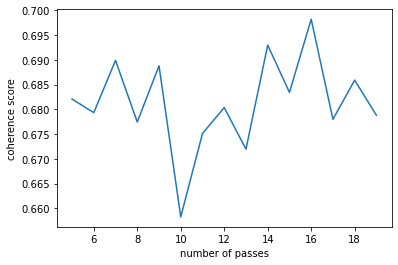

In [40]:
x=range(5,20)
plt.plot(x,coherence_values_passes)
plt.xlabel('number of passes')
plt.ylabel('coherence score')
plt.show()

#### (passes 16으로 해야겠다)

---

### 토픽 선정 및 시각화

In [41]:
ldamodel = LdaModel(corpus,
                    num_topics=13,
                    id2word=dictionary,
                    passes=16) # 감마를 어떻게 할까.... alpha
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.416*"재미있다" + 0.076*"꾸준하다" + 0.067*"지루하다" + 0.066*"괜찮다" + 0.048*"즐겁다" + 0.040*"많다" + 0.038*"유익하다" + 0.021*"딱이다"')
(1, '0.154*"아쉽다" + 0.127*"기대하다" + 0.075*"없다" + 0.069*"밉다" + 0.067*"반갑다" + 0.061*"기쁘다" + 0.037*"새롭다" + 0.033*"설레다"')
(2, '0.199*"어떻다" + 0.128*"궁금하다" + 0.093*"새롭다" + 0.092*"흥미롭다" + 0.045*"많다" + 0.032*"아니다" + 0.028*"다양하다" + 0.017*"이렇다"')
(3, '0.110*"다양하다" + 0.096*"많다" + 0.057*"없다" + 0.057*"유용하다" + 0.056*"편하다" + 0.051*"알차다" + 0.039*"자세하다" + 0.031*"가능하다"')
(4, '0.066*"아름답다" + 0.058*"없다" + 0.039*"아프다" + 0.037*"아니다" + 0.031*"깊다" + 0.029*"슬프다" + 0.018*"이렇다" + 0.018*"어떻다"')
(5, '0.739*"좋아하다" + 0.045*"만족하다" + 0.032*"빠르다" + 0.031*"즐겁다" + 0.020*"유명하다" + 0.014*"싫어하다" + 0.013*"많다" + 0.010*"다양하다"')
(6, '0.131*"예쁘다" + 0.127*"따뜻하다" + 0.090*"귀엽다" + 0.066*"행복하다" + 0.054*"이쁘다" + 0.039*"사랑스럽다" + 0.031*"잔잔하다" + 0.027*"소중하다"')
(7, '0.212*"없다" + 0.101*"아니다" + 0.057*"이렇다" + 0.029*"많다" + 0.022*"안되다" + 0.018*"솔직하다" + 0.018*"아깝다" + 0.017*"불편하다"')
(8, '0.154*"아니다" + 0.149*"많다" + 0.077*"필요하다" + 0.

In [ ]:
# 불용어 추가할 단어 : '없다','아니다',

In [ ]:
# 저장된 모델 불러오기
# ldamodel = LdaModel.load('model/nouns_13topics_16passes')
# ldamodel

In [42]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

C:\Users\multicampus\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [44]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==20:
        break
#     print(i,'번째 문서의 topic 비율은',topic_list)
    print(book_train_isbn[i],'의 topic 비율은',topic_list)

9788959752195 의 topic 비율은 [(0, 0.038461547), (1, 0.038461547), (2, 0.038461547), (3, 0.038461547), (4, 0.038461547), (5, 0.53846145), (6, 0.038461547), (7, 0.038461547), (8, 0.038461547), (9, 0.038461547), (10, 0.038461547), (11, 0.038461547), (12, 0.038461547)]
9791136202772 의 topic 비율은 [(0, 0.019231323), (1, 0.019231323), (2, 0.019231344), (3, 0.019231323), (4, 0.019231353), (5, 0.019231323), (6, 0.019231323), (7, 0.019231386), (8, 0.019231373), (9, 0.019231323), (10, 0.47042608), (11, 0.019231323), (12, 0.31802917)]
9791127420949 의 topic 비율은 [(0, 0.01098909), (1, 0.32988542), (2, 0.010989148), (3, 0.17391512), (4, 0.010989176), (5, 0.01098909), (6, 0.15781555), (7, 0.23948151), (8, 0.010989353), (9, 0.010989092), (10, 0.010989176), (11, 0.010989091), (12, 0.010989184)]
9788995797020 의 topic 비율은 [(0, 0.012821255), (1, 0.012820783), (2, 0.012820818), (3, 0.012821035), (4, 0.012820771), (5, 0.012820647), (6, 0.012820648), (7, 0.17144772), (8, 0.012820828), (9, 0.18388557), (10, 0.01282

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# 모델 저장
model_name = 'model/adj_13topics_16passes'
ldamodel.save(model_name)

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# from gensim.test.utils import datapath

# # Save model to disk.
# temp_file = datapath("model")
# lda.save(temp_file)

# # Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

----

(0, '0.416*"재미있다" + 0.076*"꾸준하다" + 0.067*"지루하다" + 0.066*"괜찮다" + 0.048*"즐겁다" + 0.040*"많다" + 0.038*"유익하다" + 0.021*"딱이다"')  
(1, '0.154*"아쉽다" + 0.127*"기대하다" + 0.075*"없다" + 0.069*"밉다" + 0.067*"반갑다" + 0.061*"기쁘다" + 0.037*"새롭다" + 0.033*"설레다"')  
(2, '0.199*"어떻다" + 0.128*"궁금하다" + 0.093*"새롭다" + 0.092*"흥미롭다" + 0.045*"많다" + 0.032*"아니다" + 0.028*"다양하다" + 0.017*"이렇다"')  
(3, '0.110*"다양하다" + 0.096*"많다" + 0.057*"없다" + 0.057*"유용하다" + 0.056*"편하다" + 0.051*"알차다" + 0.039*"자세하다" + 0.031*"가능하다"')  
(4, '0.066*"아름답다" + 0.058*"없다" + 0.039*"아프다" + 0.037*"아니다" + 0.031*"깊다" + 0.029*"슬프다" + 0.018*"이렇다" + 0.018*"어떻다"')  
(5, '0.739*"좋아하다" + 0.045*"만족하다" + 0.032*"빠르다" + 0.031*"즐겁다" + 0.020*"유명하다" + 0.014*"싫어하다" + 0.013*"많다" + 0.010*"다양하다"')  
(6, '0.131*"예쁘다" + 0.127*"따뜻하다" + 0.090*"귀엽다" + 0.066*"행복하다" + 0.054*"이쁘다" + 0.039*"사랑스럽다" + 0.031*"잔잔하다" + 0.027*"소중하다"')  
(7, '0.212*"없다" + 0.101*"아니다" + 0.057*"이렇다" + 0.029*"많다" + 0.022*"안되다" + 0.018*"솔직하다" + 0.018*"아깝다" + 0.017*"불편하다"')  
(8, '0.154*"아니다" + 0.149*"많다" + 0.077*"필요하다" + 0.058*"중요하다" + 0.047*"어떻다" + 0.033*"없다" + 0.033*"야하다" + 0.023*"단순하다"')  
(9, '0.113*"훌륭하다" + 0.097*"작다" + 0.081*"두껍다" + 0.062*"깔끔하다" + 0.055*"깊다" + 0.036*"방대하다" + 0.034*"충실하다" + 0.032*"많다"')  
(10, '0.175*"가볍다" + 0.126*"짧다" + 0.054*"멋지다" + 0.054*"즐겁다" + 0.054*"아니다" + 0.053*"다르다" + 0.047*"비슷하다" + 0.033*"무겁다"')  
(11, '0.470*"어렵다" + 0.054*"많다" + 0.053*"자세하다" + 0.047*"맛있다" + 0.039*"간단하다" + 0.035*"건강하다" + 0.029*"정확하다" + 0.025*"복잡하다"')  
(12, '0.224*"재밌다" + 0.126*"재미있다" + 0.055*"없다" + 0.038*"아니다" + 0.025*"흥미롭다" + 0.020*"지루하다" + 0.018*"신선하다" + 0.017*"이렇다"')  

9788959752249 의 topic 비율은 [(0, 0.110259295), (1, 0.018089121), (3, 0.50538033), (5, 0.024463095), (6, 0.021185478), (9, 0.099900566), (11, 0.18373302), (12, 0.030240469)]  
<쉽게 배우는 만화 캐릭터 데생 - 그리기의 기본기부터 인체구조, 얼굴, 몸, 움직임, 의상까지>  
3 - 재미감    
11 - 깊이감?   
9 - 어려운지? 
0 -  재미, 지루함?

---
국내도서 > 만화 > 만화그리기와 읽기 > 만화작법/일러스트  
국내도서 > 예술/대중문화 > 미술 > 미술 실기  

---

만화 캐릭터 그리는 법과 그 과정을 소개한 책. 제목에 ‘데생’이라는 말이 붙어있는데, 만화 캐릭터를 잘 그리기 위해 필요한 여러 가지 기초 과정을 ‘데생’이라고 부른다. ‘만화 형식의 유래’를 더욱 쉽게 이해할 수 있도록 그림과 해설을 접목해 놓았다. 책은 미술해부학을 바탕으로 깔려있으며, 자기 몸을 사용해서 자기가 그리려고 하는 이미지와 가장 가까운 모습을 찾아내는 방법을 알려준다.

또한, 여러 가지 표현과 정통적이고 범용적인 그림을 많이 넣어 캐릭터를 그리는 기본기와 응용 요령을 습득할 수 있게 도와주고, 책 틈틈이 '브레이크 타임'을 넣어 일러스트레이터가 되는 법이나 일러스트레이터에게 필요한 것 등 누구도 알려주지 않는 중요한 팁들을 독자들에게 친절하게 알려준다